# Build a language model based on wikipedia in you language 

The notebooke includes the whole process but you will need to help the process if the following problem happens:  
-you internet connection is interrupted (stage 1)

-you run out of diskspace

-because of the huge memory consumption. creatig the databunch for the training requires lots of memory


In order ot handle these problemn the notebook is divided into stages. If the process is failes in a stage then you can resume the processing from the beginning of that stage by:
-restarting the kernel "Kernel"/Restart & Clear Output

-running the cells in stage 0: initialization

-running the cells from the start of the stage that failed 

# Stage 0: Initialisation
lang: You must set the parameter "lang" to the language you want to build a model for. Fx:

fr: for french

en: for english

de:for german

da: for danish 

etc.

pathData: You must se the location where you want your data stored using the parameter pathData. Consider using a ssd-rive

In [1]:
lang="en"

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.text import * 

from IPython.display import display, HTML
from pathlib import *
import re
import shutil

In [4]:
pathData       = Path("../../data/nlp")
path           = pathData / lang
pathDump       = path/"wiki-dump"
pathJson       = path/"wiki-json"

pathTrainValid = path/"wiki-train_valid"
pathTxt        = pathTrainValid/"txt"
pathToks       = pathTrainValid/"toks"
pathcsv        = pathTrainValid/"wiki.csv"

cache_name   = "sp-model"
pathVocab    = pathTrainValid / cache_name

# requried libraries: 
conda install -c anaconda psutil 

conda install -c anaconda git 

#conda install -c menpo wget 
conda install curl


# Stage 1: download the selected language from wikipedia and convert the articles to json

In [5]:
if len(list(pathDump.glob("*.bz2")))==0:
    pathDump.mkdir(parents=True,exist_ok=True)
    #fn  = f"{lang}wiki-latest-pages-articles.xml.bz2"
    fn  = f"{lang}wiki-latest-pages-articles-multistream.xml.bz2"
    url = f"https://dumps.wikimedia.org/{lang}wiki/latest/{fn}"
    #cmd = f"wget -c --no-check-certificate --show-progress {str(url)} -P {str(pathDump)}"
    cmd = f'curl -k -C - -o "{str(pathDump/fn)}" "{str(url)}"'
    print(f"If the command fails in the notebook then copy the command and run it in the terminal:{cmd}")
    ! $cmd

# Stage 2: Convert wikipedia dump to articles in json

In [6]:
pathWikiExtractor = Path("../wikiextractor")

In [7]:
if not pathJson.exists():
    !git clone https://github.com/attardi/wikiextractor.git $pathWikiExtractor
    cmd = f"cd {str(pathWikiExtractor)} && python setup.py install"
    ! $cmd

In [8]:
%%time
if not pathJson.exists():
    #extracting the json-files. This takes about 1 hour for french with files read from and saved to a ssd hardrive 
    fn_wikidump = list(pathDump.iterdir())[0]
    cmd = f"cd {str(pathWikiExtractor)} && python WikiExtractor.py -o {str(pathJson)} --json --processes {defaults.cpus} -q  {str(fn_wikidump)}"
    print(f"If WikiExtractor fails in the notebook then copy the command and run it in the terminal:{cmd}")
    ! $cmd

Wall time: 0 ns


# Stage 3: building a vocabulary using sentencepiece

Now we separate the title of the wikipedia section from text section that we keep. 

In order to makes a first reduction on the number of section we clean the text with the preprocessing rules from fastai and ignore text with less than "minWords"

You must set the lenght of the shortes sections you want to keep using the parameter "minWords"

In [9]:
minWords  = 10
chunksize = 25000

In [10]:
!pip install sentencepiece

In [11]:
from fastai_sentencepiece import *
from filetokenizer import *
from languagemodelloader import *

In [12]:
if not pathTxt.exists():
    swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab, minWords=minWords )    
    %time swm.wikijson2TrainingData()   


In [13]:
if not (pathVocab/"m.model").exists():
    swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab, minWords=minWords)
    %time swm.trainVocabulary()

In [14]:
if not (pathVocab/"itos.pkl").exists():
    swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab, minWords=minWords)
    swm.convertVocab()

# Show some examples using the vocabulary

In [15]:
swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab, minWords=minWords)
sp = spm.SentencePieceProcessor()
sp.Load(str(pathVocab / "m.model"))
print("1: Size of vocabulary:",sp.GetPieceSize())
sentence = "She is tall. He is small"
print("2:", sp.EncodeAsPieces(sentence))
print("3:", sp.EncodeAsIds(sentence))


1: Size of vocabulary: 32000
2: ['▁She', '▁is', '▁tall', '.', '▁He', '▁is', '▁small']
3: [118, 18, 3920, 9, 40, 18, 322]


In [16]:
print(f"Control symbol")
for s in ["<unk>"]: print(f"{s}({sp.PieceToId(s)})")

print(f"\nuser_defined_symbols")
for s in swm.getUserdefinedSymbols():print(f"{s}({sp.PieceToId(s)})")

Control symbol
<unk>(0)

user_defined_symbols
xxfld(0)
xxmaj(3)
xxup(4)
xxrep(5)
xxwrep(6)


# Prepare training of the language model

# Create Tokenizer
The sentencepiece vocabulary was trained in Train Sentencepiece tokenizer.ipynb.

Here we will make a BasicTokenizer from Sentencepiece

In [17]:
spt_func  = partial(SentencepieceTokenizer.create, pathVocab=pathVocab)
spt_func.__name__ = SentencepieceTokenizer.__name__
spt       = spt_func(lang="en")
tokenizer = Tokenizer(spt_func,"en")

pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab  = spt.vocab(), len(spt.vocab().itos)

print(tokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
sentence = ["She is tall.", "He is small"]
tokenizer._process_all_1(sentence)

print("vocab:",vocab)

Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - rm_extra_lineshift
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 0
[0, 1, 0, 3, 4, 5, 6, 0]
vocab: <fastai.text.transform.Vocab object at 0x0000022FA18F5EF0>


# LM Training
Set the minimum number of tokens for the sections that we shall retain

In [18]:
#Discard section with kess than "minTok" tokens
minToks = 10

In [19]:
pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab = spt.vocab(), len(spt.vocab().itos)
trainTokenizer = FileTokenizer(pathToks/"train", spt_func,"en",vocab,minToks=minToks,n_cpus=max(defaults.cpus-1,1))
validTokenizer = FileTokenizer(pathToks/"valid", spt_func,"en",vocab,minToks=minToks,n_cpus=max(defaults.cpus-1,1))

print(trainTokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
#sentence = ["She is tall.", "He is small"]
#tokenizer._process_all_1(sentence)

self.dtype:<class 'numpy.int16'>
self.dtype:<class 'numpy.int16'>
Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - rm_extra_lineshift
 - rm_extra_lineshift
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 0
[0, 1, 0, 3, 4, 5, 6, 0]


In [20]:
files   = np.asarray( list(pathTxt.glob("*.txt")) )
nrows   = len(files)
split   = 0.2
splitindex, index = int(nrows*split+.5), np.random.permutation(np.arange(nrows)) 

chunksize=0

trainList = TextList( files[:-splitindex], vocab=vocab, pad_idx=pad_idx, 
                      processor=[FileTokenizeProcessor(tokenizer=trainTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)])

validList = TextList( files[-splitindex:], vocab=vocab, pad_idx=pad_idx, 
                      processor=[FileTokenizeProcessor(tokenizer=validTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)])


In [21]:
if not (pathToks/"train").exists():
    %time trainList.process()
    trainList=None

In [22]:
if not (pathToks/"valid").exists():
    %time p = validList.process()
    validList=None

In [23]:
%time trainIDS = trainTokenizer.getIds()

Wall time: 1min 6s


In [24]:
%time validIDS=validTokenizer.getIds()

Wall time: 16.1 s


Traning:    number of arrays:27391909 - number of ids:-2019910006
Validation: number of arrays:6560301 - number of ids:548245997
Lenght of token rags min:10 max:13667 - median:66.0
rags > 1000 tokes:878
Wall time: 9.55 s


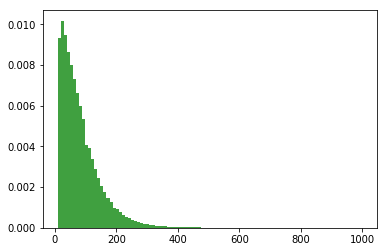

In [25]:
%%time
print(f"Traning:    number of arrays:{len(trainIDS)} - number of ids:{np.sum([len(ids) for ids in trainIDS])}")
print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{np.sum([len(ids) for ids in validIDS])}")

#Analyse the distribution of the legnth of tokens sequences in the ragged/jagged array of tokes
sectionlengths = np.asarray([len(s) for s in trainIDS],dtype=np.int32)
plt.hist(sectionlengths[sectionlengths<1000], 100, density=True, facecolor='g', alpha=0.75)
np.histogram(sectionlengths[sectionlengths<1000],50)

print(f"Lenght of token rags min:{min(sectionlengths)} max:{np.max(sectionlengths)} - median:{np.median(sectionlengths)}")
print(f"rags > 1000 tokes:{np.sum(sectionlengths>1000)}")
sectionlengths[:20]

In [26]:
percent     = np.asarray([ 25,50,75,90,97,99,100]) # %np.arange(101,dtype=np.int)
percentiles = np.percentile(sectionlengths,percent).astype(np.int)
print("%  percentile")
for i in range(len(percent)):print(f"{percent[i]}  {percentiles[i]}")

%  percentile
25  35
50  66
75  111
90  166
97  241
99  314
100  13667


In [34]:
from fastai.basics import * 
from fastai.text import * 
from languagemodelloader import *

#nTrainToks, nValidToks = int(5e5),int(2e5)
nTrainToks, nValidToks = int(5e4),int(1e4)
if nTrainToks>0 and nValidToks>0:
    trainIDS_ = trainIDS[0:nTrainToks]
    validIDS_ = validIDS[0:nValidToks]
else:
    trainIDS_ = trainIDS
    validIDS_ = validIDS

dblm = MyTextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS_, validIDS_, bptt=70, p_bptt=0.1, bs=32)
#dblm = TextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS_, validIDS_, bptt=70,  p_bptt=0.95, bs=32)
nTrainToks, nValidToks

MyTextLMDataBunch def create


(50000, 10000)

In [28]:
(6*60+54)/(8*60+10)*100

84.48979591836735

In [29]:
len(dblm.train_ds.vocab.itos)

32000

In [30]:
dblm.show_batch()

idx,text
0,"▁his ▁pamphlet ▁"" xxmaj the ▁art ▁of ▁organ ▁building ▁and ▁organ ▁play ing ▁in xxunk ▁and xxunk "" ▁(19 06 , ▁republished ▁with ▁an ▁append ix ▁on ▁the ▁state ▁of ▁the ▁organ - building ▁industry ▁in ▁1927 ) ▁effectively ▁launched ▁the ▁20 th - century ▁"" xxmaj or gel be we g ung "", ▁which ▁turned ▁away ▁from ▁romantic ▁extreme s ▁and ▁rediscovered ▁baroque ▁principles — although ▁this ▁sweep ing"
1,"v ) ▁chains ▁are ▁responsible ▁for ▁binding ▁to ▁the ▁antigen . ▁these ▁loop s ▁are ▁referred ▁to ▁as ▁the ▁complement ar ity ▁determin ing ▁regions ▁( c xxup dr s ). ▁each ▁of ▁the ▁panels ▁works ▁to ▁identify , ▁coordinate , ▁and ▁harm on ize ▁voluntary ▁standards ▁relevant ▁to ▁these ▁areas . ▁the xxunk - xxmaj american ▁trend ▁of ▁voting ▁for xxunk ▁can ▁be ▁traced ▁back ▁to ▁the ▁1930 s"
2,"▁him ▁a ▁son ▁to ▁be ▁called xxup ▁a ene as . ▁however , ▁she ▁war ns ▁him ▁that ▁he ▁must ▁never ▁tell ▁anyone ▁that ▁he ▁has ▁la in ▁with ▁a ▁goddess . ▁when xxup ▁a ene as ▁is ▁born , xxup ▁a phro d ite ▁takes ▁him ▁to ▁the ▁ ny mph s ▁of ▁mount xxunk . ▁she ▁direct s ▁them ▁to ▁raise ▁the ▁child ▁to ▁age ▁five , ▁then"
3,"tern ity . ▁the ▁day ▁of ▁judgment ▁is ▁described ▁as ▁passing ▁over xxunk ▁on ▁a ▁narrow ▁bridge ▁( as ▁thin ▁as ▁human ▁hair ▁and ▁sharp er ▁than ▁a ▁ raz or ) ▁in ▁order ▁to ▁enter xxunk . ▁those ▁who ▁fall , ▁weight ed ▁by ▁their ▁bad ▁de ed s , ▁will ▁remain ▁in xxunk ▁for ever . ▁on ▁21 xxunk ▁2012, xxup ▁e xxup sa ▁agreed ▁to ▁continue ▁with"
4,"▁conglomerate s . ▁on xxunk ▁14, ▁1986, xxup ▁l er ner ▁died ▁of ▁lung ▁cancer ▁in xxunk ▁at ▁the ▁age ▁of ▁67 . ▁at ▁the ▁time ▁of ▁his ▁death ▁he ▁was ▁married ▁to ▁actress xxunk xxunk , ▁who ▁was ▁36 ▁years ▁his ▁junior . ▁he ▁lived ▁in ▁center ▁island , ▁new xxunk . ▁he ▁has ▁a ▁memorial ▁plaque ▁in ▁st xxunk ' s ▁church , ▁the ▁actor ' s ▁church"


In [31]:
%time learn = language_model_learner(dblm, drop_mult=0, qrnn=False, pad_token=-1, callback_fns=ShowGraph)

Wall time: 1.17 s


epoch,train_loss,valid_loss,accuracy
1,5.021715,5.270501,0.215173


len(self):2425 Number of iteration:2425
totalTokens:5429884 processedTokens:5334208 processedTokens-totalToks:-95676
len(self):332 Number of iteration:332
totalTokens:742377 processedTokens:739520 processedTokens-totalToks:-2857


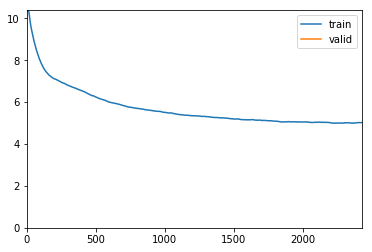

Wall time: 4min 1s


In [32]:
#%load_ext line_profiler
%time learn.fit_one_cycle(1,2e-3, moms=(0.8,0.7))

C:\projects\sentencepiece\src\trainer_interface.cc(363) LOG(INFO) Done: 100% characters are covered.
C:\projects\sentencepiece\src\trainer_interface.cc(373) LOG(INFO) Alphabet size=5727
C:\projects\sentencepiece\src\trainer_interface.cc(374) LOG(INFO) Final character coverage=1
C:\projects\sentencepiece\src\trainer_interface.cc(406) LOG(INFO) Done! preprocessed 998659 sentences.
C:\projects\sentencepiece\src\unigram_model_trainer.cc(129) LOG(INFO) Making suffix array...
[I 14:36:20.223 NotebookApp] Saving file at /nlp/nonsens scratchpad.ipynb
C:\projects\sentencepiece\src\unigram_model_trainer.cc(133) LOG(INFO) Extracting frequent sub strings...
C:\projects\sentencepiece\src\unigram_model_trainer.cc(184) LOG(INFO) Initialized 1000000 seed sentencepieces
C:\projects\sentencepiece\src\trainer_interface.cc(412) LOG(INFO) Tokenizing input sentences with whitespace: 998659
C:\projects\sentencepiece\src\trainer_interface.cc(421) LOG(INFO) Done! 2058688
C:\projects\sentencepiece\src\unigram_model_trainer.cc(472) LOG(INFO) Using 2058688 sentences for EM training

In [ ]:
#i have an issue with passing pad_idx